In [1]:
%matplotlib inline
from pylab import *
from Game import *
from Game.minimax import *
inf=1e500

Version:  0.3.04


In [2]:
def initial_state():
    state=Board(3,3)
    state.pieces=['.','X','O']
    # state[0]=1 in cases where we need to have starting pieces
    return state


# In[3]:


def valid_moves(state,player):
    
    # nope -- return [0,1,2,3,4,5,6,7,8]
    
    EMPTY=0
    X=1
    O=2
    
    moves=[]
    
    if state[0]==0:
        moves.append(0)
    if state[1]==0:
        moves.append(1)        
    if state[2]==0:
        moves.append(2)
        
    #....
    
    moves=[]
    for location in range(9):
        if state[location]==EMPTY:
            moves.append(location)
    
    
    return moves


# In[4]:


def update_state(state,player,move):
    
    new_state=state
    
    new_state[move]=player
    
    return new_state


# In[5]:


def three_in_a_row(a,b,c,player):
    
    if a==player and b==player and c==player:
        return True
    else:
        return False
    
    
    
def win_status(state,player):
    
    # 0 1 2
    # 3 4 5
    # 6 7 8
    
    if player==1:
        other_player=2
    else:
        other_player=1
    
    if three_in_a_row(state[0],state[1],state[2],player):
        return 'win'
    if three_in_a_row(state[3],state[4],state[5],player):
        return 'win'
    if three_in_a_row(state[6],state[7],state[8],player):
        return 'win'
    if three_in_a_row(state[0],state[3],state[6],player):
        return 'win'
    if three_in_a_row(state[1],state[4],state[7],player):
        return 'win'
    if three_in_a_row(state[2],state[5],state[8],player):
        return 'win'
    if three_in_a_row(state[0],state[4],state[8],player):
        return 'win'
    if three_in_a_row(state[2],state[4],state[6],player):
        return 'win'
    
    if not valid_moves(state,other_player):
        return 'stalemate'
    
    
def show_state(state):
    print(state)
    
    


# In[6]:


In [3]:
class Node():

    def __init__(self,value,m=50,h=100):
        self.value=value
        self.children=[]
        self.parent=None
        self.x=0
        self.y=0
        self.abs_xy=None
        self.ext=[-m,m]
        self.m=m
        self.h=h

    def __iadd__(self,y):
        try:
            for item in y:
                self.children.append(item)
                item.parent=self
        except TypeError:
            self.children.append(y)

        return self

In [4]:
def get_xy(node):
    import numpy as np
    
    if node.abs_xy is None:
        adjust_extents(node)
    x=[]
    y=[]
    labels=[]
     
    def _traverse(node,parent_x=0,depth=0):
        node.abs_xy=[node.x+parent_x,-node.y]
        x.append(node.x+parent_x)
        y.append(-node.y)
        labels.append(str(node.value)[:-1])
        for child in node.children:
            _traverse(child,node.x+parent_x,depth+1)
            
    _traverse(node)   

    return np.array(x),np.array(y),labels

In [5]:
def adjust_extents(node,depth=0):

    node.y=node.h*depth

    if not node.children:
        node.x=0
        node.ext=[-node.m,node.m]
        return

    for c in node.children:
        adjust_extents(c,depth+1)    

    cdf=0
    for c in node.children:
        df=c.ext[1]-c.ext[0]
        c.x=cdf+df/2
        cdf+=df

    for c in node.children:
        c.x-=cdf/2

    node.ext=[-cdf/2,+cdf/2]

In [20]:
def get_lines2(node):
    import numpy as np
    if node.abs_xy is None:
        adjust_extents(node)

    x=[]
    y=[]

    def _traverse(node,parent_x=0,depth=0):        
        for child in node.children:
            x.append([node.abs_xy[0],child.abs_xy[0]])
            y.append([node.abs_xy[1],child.abs_xy[1]])

            _traverse(child)
    _traverse(node)            

    return np.array(x),np.array(y)
    

def get_lines(node):
    import numpy as np
    if node.abs_xy is None:
        adjust_extents(node)

    x=[]
    y=[]

    def _traverse(node,parent_x=0,depth=0):        
        for child in node.children:
            x.append([node.abs_xy[0]])
            y.append([node.abs_xy[1]])
            x.append([child.abs_xy[0]])
            y.append([child.abs_xy[1]])
            x.append([np.nan])
            y.append([np.nan])

            _traverse(child)
    _traverse(node)            

    return np.array(x),np.array(y)
    

In [21]:
def tree(current_state,player,depth=0,maxdepth=inf,m=50,h=100):

    node=Node(deepcopy(current_state),m=m,h=h)
    
    if player==1:
        other_player=2
    else:
        other_player=1

    if depth>maxdepth:
        return 
    
    # since win_status is called with a player and an updated state
    # the current state is really the updated state from the
    # other player's last move.

    status=win_status(current_state,other_player)
    if not status in ['win','lose','stalemate',None]:
        raise ValueError("Win status returned '%s' not valid.  Allowed values only in ['win','lose','stalemate',None]." % status)

    if status=='win':  # bad for min
        return node
    elif status=='lose':  # good for min
        return node
    elif status=='stalemate':  # draw
        return node


    moves=valid_moves(current_state,player)
    if moves is None:
        raise ValueError("valid_moves returned None with state=%s and player=%d - Did you forget to return the moves?" % (str(current_state),player))
    available_states=[update_state(deepcopy(current_state),player,move)
                                for move in moves]
    
    for state in available_states:
        node+=tree(state,other_player,depth+1,maxdepth,m=m,h=h)

    return node
    

In [22]:
state=Board(3,3)
for loc in [0,7,8]:
    state[loc]=2
for loc in [2,3,6]:
    state[loc]=1
#state.pieces=['.','X','O']
state

 2  0  1 
 1  0  0 
 1  2  2 

(np.float64(-220.0), np.float64(220.0), np.float64(-317.0), np.float64(17.0))

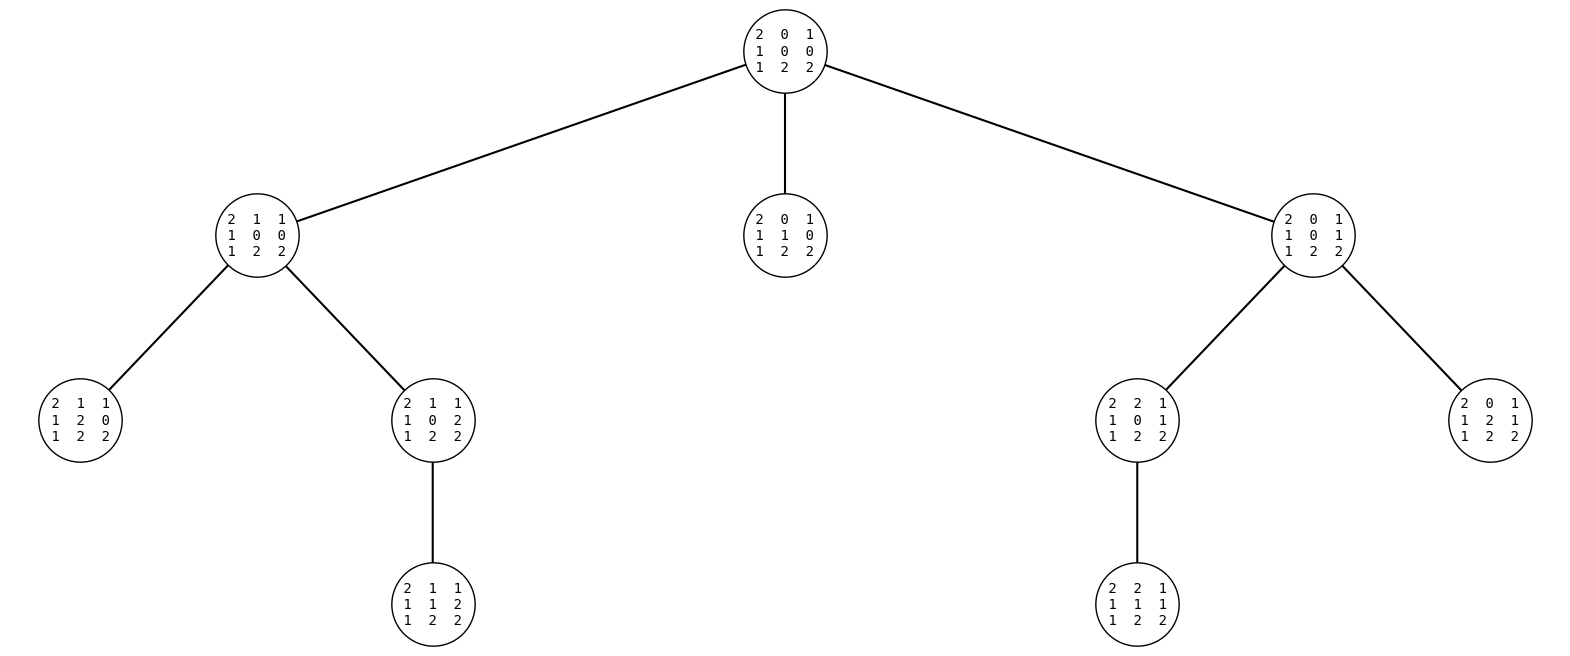

In [23]:
node=tree(state,1)
x,y,labels=get_xy(node)
xl,yl=get_lines(node)
figure(figsize=(20,8))
plot(xl,yl,'k-')
plot(x,y,'o',color='white',markeredgecolor='black',markersize=60, clip_on=False)
for xx,yy,L in zip(x,y,labels):
    text(xx,yy,L,ha='center',va='center',color='black',fontfamily='monospace')
xl=gca().get_xlim()
yl=gca().get_ylim()
gca().set_ylim([yl[0]-2,yl[1]+2])
axis('off')

In [24]:
from drawio import *
from IPython.core.display import SVG

(-317.0, 17.0)

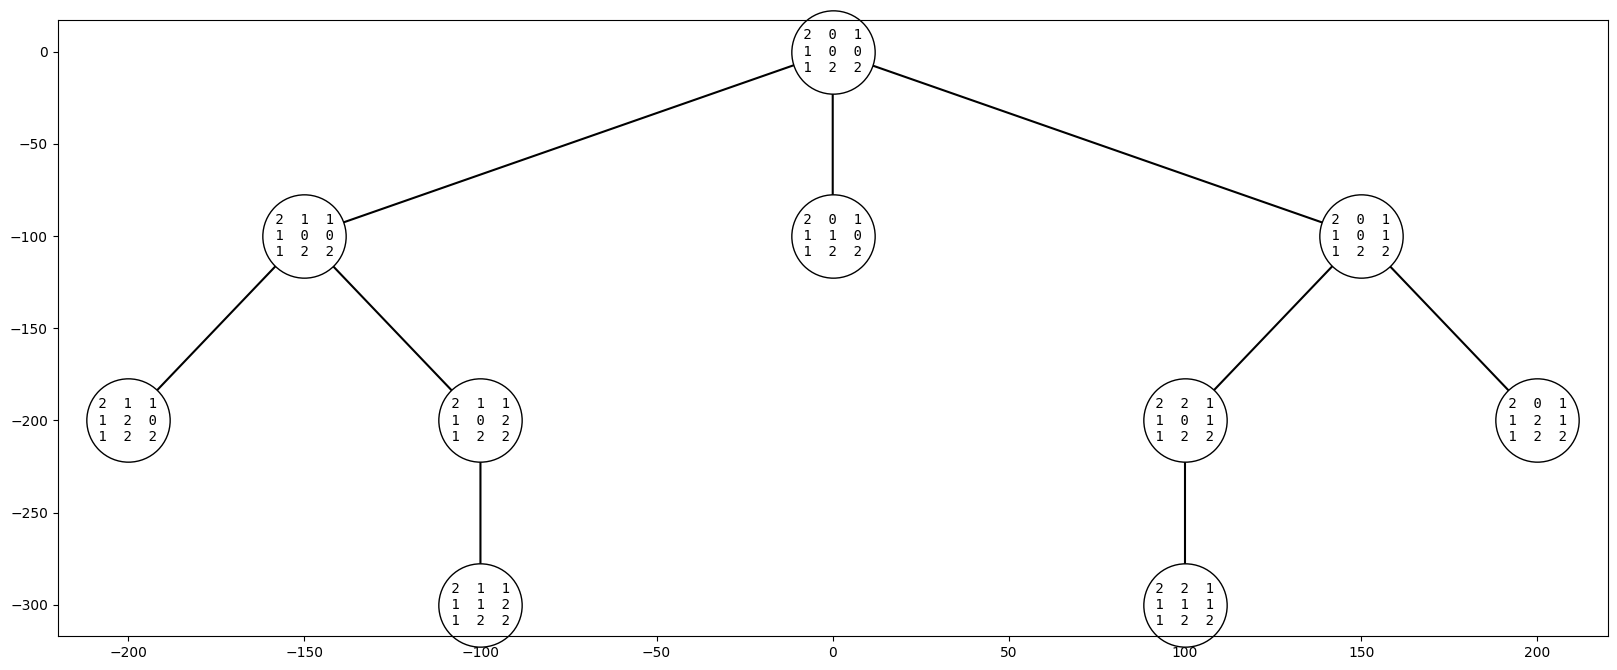

In [25]:
node=tree(state,1)
x,y,labels=get_xy(node)
xl,yl=get_lines(node)
figure(figsize=(20,8))
plot(xl,yl,'k-')
plot(x,y,'o',color='white',markeredgecolor='black',markersize=60, clip_on=False)
for xx,yy,L in zip(x,y,labels):
    text(xx,yy,L,ha='center',va='center',color='black',fontfamily='monospace')
xlim=gca().get_xlim()
ylim=gca().get_ylim()
gca().set_ylim([ylim[0]-2,ylim[1]+2])

In [33]:
def state2text(state):
    S=str(state)
    S=S.replace("\n","&lt;br&gt;")
    text=f"&lt;pre style=&quot;line-height: 50%;&quot;&gt;&lt;font face=&quot;Courier New&quot;&gt;&lt;span style=&quot;font-size: 5px;&quot;&gt;{S}&lt;/span&gt;&lt;/font&gt;&lt;/pre&gt;"    
    return text

Saving minimax_test.drawio...done.
/Applications/draw.io.app/Contents/MacOS/draw.io --export --format svg --crop --transparent "minimax_test.drawio" "minimax_test.svg"
minimax_test.drawio -> minimax_test.svg


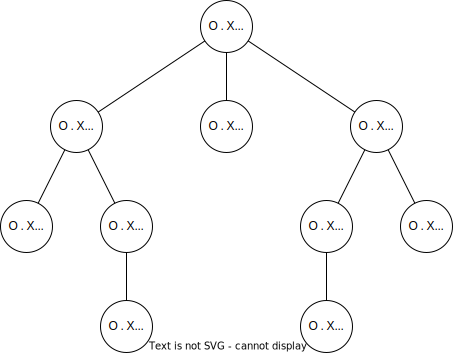

In [35]:
width=max(x)+30
height=max(y)+30

state.pieces=['.','X','O']
d = drawio(width, height)
xl,yl=get_lines2(node)

for xx,yy in zip(xl,yl):
    d.line(xx[0], height-yy[0],xx[1],height-yy[1],strokeColor='black')

for xx,yy,L in zip(x,y,labels):
    d.circle(xx,height-yy,26,text=state2text(state))
    #text(xx,yy,L,ha='center',va='center',color='black',fontfamily='monospace')



sfname='minimax_test.svg'
d.save(sfname,verbose=True)

SVG(filename=sfname)

In [29]:
str(state)

' 2  0  1 \n 1  0  0 \n 1  2  2 \n'

In [13]:
x

array([150., 200.])

In [38]:
state=Board(3,3)
for loc in [0,7]:
    state[loc]=2
for loc in [2,3,6]:
    state[loc]=1
state.pieces=['.','X','O']
state

 O  .  X 
 X  .  . 
 X  O  . 

Saving minimax_test.drawio...done.
/Applications/draw.io.app/Contents/MacOS/draw.io --export --format pdf --crop --transparent "minimax_test.drawio" "minimax_test.pdf"
minimax_test.drawio -> minimax_test.pdf
Saving minimax_test.drawio...done.
/Applications/draw.io.app/Contents/MacOS/draw.io --export --format svg --crop --transparent "minimax_test.drawio" "minimax_test.svg"
minimax_test.drawio -> minimax_test.svg


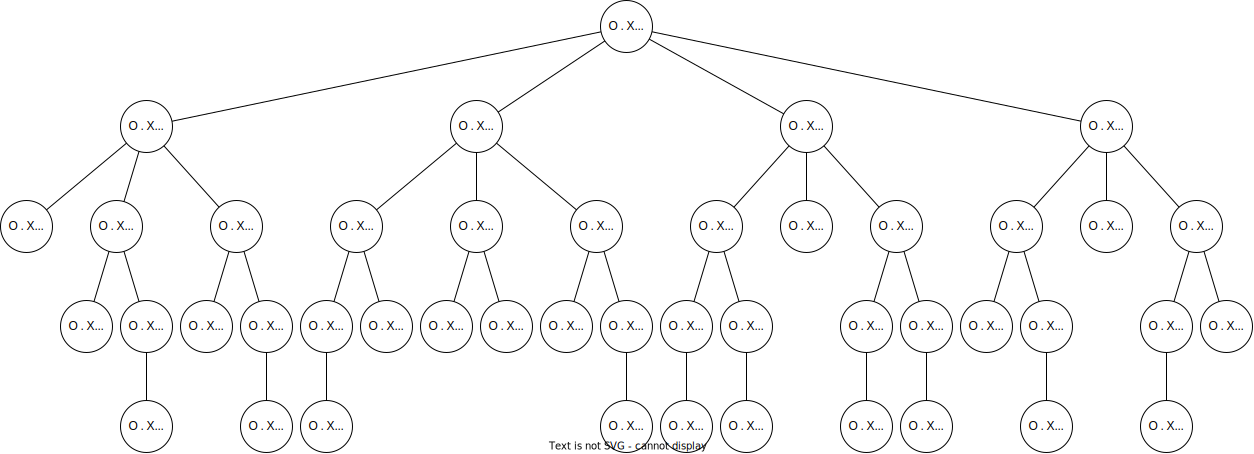

In [41]:
width=max(x)+30
height=max(y)+30

state.pieces=['.','X','O']
d = drawio(width, height)
xl,yl=get_lines2(node)

for xx,yy in zip(xl,yl):
    d.line(xx[0], height-yy[0],xx[1],height-yy[1],strokeColor='black')

for xx,yy,L in zip(x,y,labels):
    d.circle(xx,height-yy,26,text=state2text(state))
    #text(xx,yy,L,ha='center',va='center',color='black',fontfamily='monospace')



sfname='minimax_test.pdf'
d.save(sfname,verbose=True)


sfname='minimax_test.svg'
d.save(sfname,verbose=True)

SVG(filename=sfname)

In [44]:
state=Board(3,3)
for loc in [0,7]:
    state[loc]=2
for loc in [3,6]:
    state[loc]=1
state.pieces=['.','X','O']
show_state(state)


 O  .  . 
 X  .  . 
 X  O  . 



Saving minimax_test.drawio...done.
/Applications/draw.io.app/Contents/MacOS/draw.io --export --format pdf --crop --transparent "minimax_test.drawio" "minimax_test.pdf"
minimax_test.drawio -> minimax_test.pdf
Saving minimax_test.drawio...done.
/Applications/draw.io.app/Contents/MacOS/draw.io --export --format svg --crop --transparent "minimax_test.drawio" "minimax_test.svg"
minimax_test.drawio -> minimax_test.svg


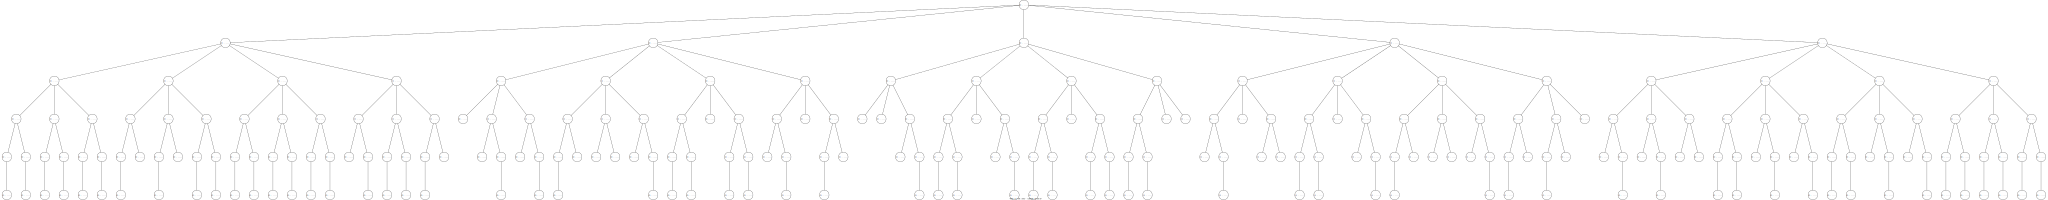

In [54]:

node=tree(state,1,m=50,h=200)
x,y,labels=get_xy(node)
xl,yl=get_lines(node)
width=max(x)+30
height=max(y)+30

state.pieces=['.','X','O']
d = drawio(width, height)
xl,yl=get_lines2(node)

for xx,yy in zip(xl,yl):
    d.line(xx[0], height-yy[0],xx[1],height-yy[1],strokeColor='black')

for xx,yy,L in zip(x,y,labels):
    d.circle(xx,height-yy,node.m//2,text=state2text(state))
    #text(xx,yy,L,ha='center',va='center',color='black',fontfamily='monospace')



sfname='minimax_test.pdf'
d.save(sfname,verbose=True)


sfname='minimax_test.svg'
d.save(sfname,verbose=True)

SVG(filename=sfname)